# First Programming Language Tweets, etc

There is a Twitter meme that is currently circulating that was started (I think) by [@cotufa82](https://twitter.com/cotufa82) where you list programming languages by particular categories including:

* first language
* had difficulties
* most used
* totally hate
* most loved
* for beginners

I thought it could be interesting to try to collect these and tabulate them...

<a href="https://twitter.com/cotufa82/status/1179601883448655874"><img style="border: thin solid black;" width=700 src="images/tweet.png"></a>

We can use [twint](https://github.com/twintproject/twint) to download search results for the query ["First language" AND "Most used" AND "Most loved"](https://twitter.com/search?q=%22First%20language%22%20AND%20%22Most%20used%22%20AND%20%22Most%20loved%22) from Twitter's search results.

Note: it skips doing the data collection if the data file is already present...

In [93]:
import os
import twint

config = twint.Config()
config.Search = '"First language" AND "Most used" AND "Most loved"'
config.Store_json = True
config.Output = "data/languages.json"
config.Hide_output = True

# this is needed when using twint in a Jupyter Notebook
# or else you'll see a weird error about the event loop already running
import nest_asyncio
nest_asyncio.apply()

if not os.path.isfile('data/languages.json'):
    twint.run.Search(config)

Collect the text of the tweets into an list:

In [3]:
import json

tweets = []
for line in open('data/languages.json'):
    t = json.loads(line)
    tweets.append(t['tweet'])

print(len(tweets))

14539


In [4]:
tweets[0]

'1. First language: Fortran 77 (ehm...) 2. Had difficulties: C++  3. Most used: IDL 4. Totally hate: Python 5. Most loved: Julia 6. For beginners: Julia 7. Currently: Julia  8. Honorable mentions: Julia  https://twitter.com/FuzzyDarkMatter/status/1180798407855792128\xa0…'

Now for the nasty part: parsing the text of the tweets. Unfortunately twint strips new lines from the text of tweets, so it's a bit harder that it needs to be. Each category can have multiple languages for example:

    Most used: PHP, JavaScript

In [94]:
import re

def parse(s):
    results = {}
    parts = [p[0] for p in re.findall(r'\d\. (.+?)(?=(\d\.)|( http)|( What about you)|$)', s)]
    for part in parts:
        try:
            k, v = [s.strip() for s in re.split(r":|-", part)[0:2]]
            category = k.lower()
            langs = [l.lower() for l in re.split(' *(?:/|(?:and)|\&|,) *', v)]
            results[category] = langs
        except ValueError as e:
            return None
    return results

print('tweet text: ', tweets[200])
print()
print('parsed: ', parse(tweets[200]))


tweet text:  1. First language: C 2. Had difficulties: Assembly 3. Most used: PHP, JavaScript  4. Totally hate: Assembly 5. Most loved: Python, Go 6. For beginners: Python

parsed:  {'first language': ['c'], 'had difficulties': ['assembly'], 'most used': ['php', 'javascript'], 'totally hate': ['assembly'], 'most loved': ['python', 'go'], 'for beginners': ['python']}


Now iterate through all the tweets and count them all by category:

In [109]:
from collections import defaultdict, Counter

counter = defaultdict(Counter)

for tweet in tweets:
    results = parse(tweet)
    if results is not None:
        for cat, langs in results.items():
            for lang in langs:
                counter[cat][lang] += 1
                
print(counter['first language'].most_common(25))

[('basic', 1759), ('c', 1527), ('c++', 1007), ('java', 928), ('pascal', 873), ('qbasic', 467), ('python', 454), ('php', 430), ('visual basic', 363), ('javascript', 265), ('logo', 230), ('html', 226), ('c#', 211), ('turbo pascal', 177), ('fortran', 144), ('english', 117), ('vb', 110), ('c64 basic', 100), ('perl', 83), ('ti', 80), ('sinclair basic', 73), ('actionscript', 73), ('matlab', 70), ('gw', 66), ('delphi', 63)]


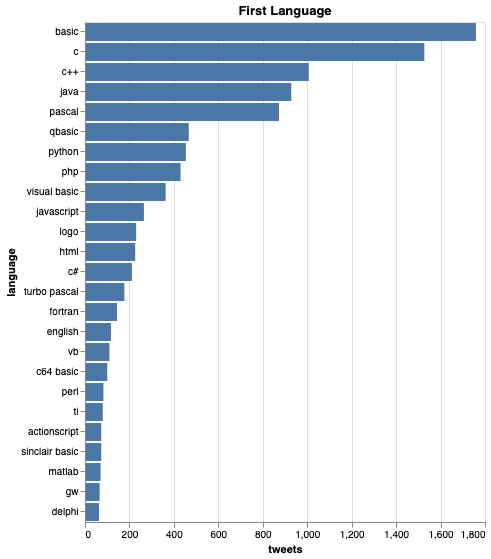

In [110]:
import altair
import pandas

altair.renderers.enable('notebook')

def chart(title, counts, top=25):
    df = pandas.DataFrame(counts.most_common(25), columns=['language', 'tweets'])
    chart = altair.Chart(df, title=title).mark_bar().encode(
        altair.X('tweets:Q'),
        altair.Y('language:O', sort=altair.EncodingSortField(field='tweets', order='descending'))
    )
    return chart

chart('First Language', counter['first language']).display()

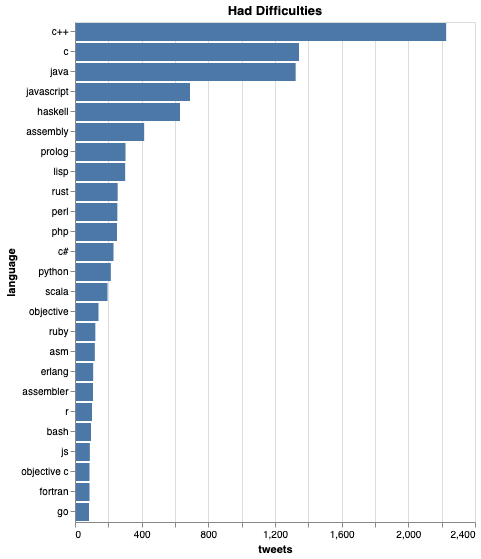

In [98]:
chart('Had Difficulties', counter['had difficulties']).display()

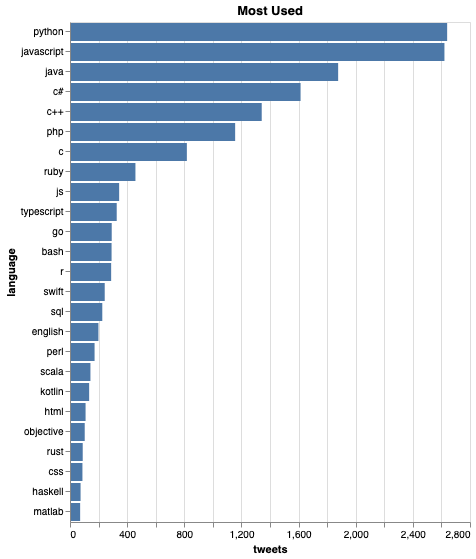

In [99]:
chart('Most Used', counter['most used']).display()

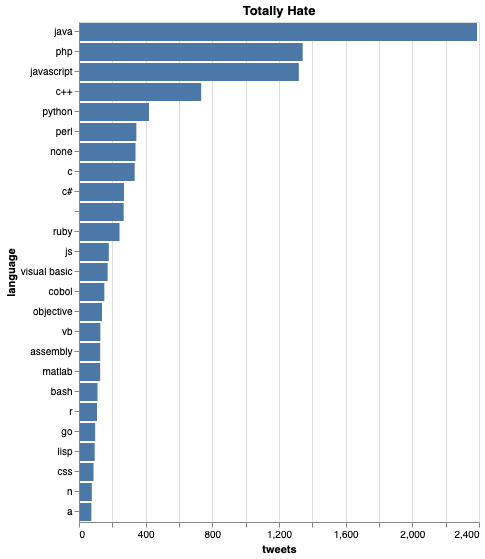

In [100]:
chart('Totally Hate', counter['totally hate']).display()

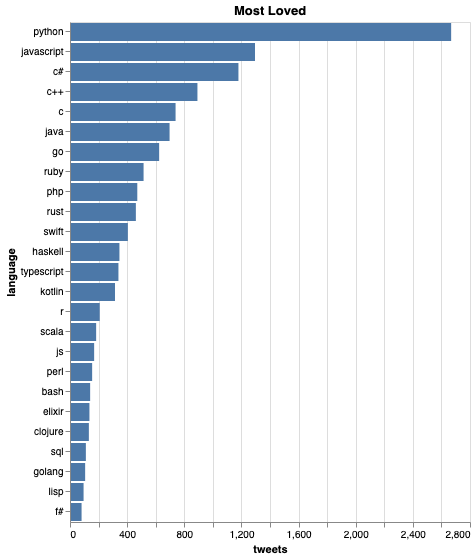

In [101]:
chart('Most Loved', counter['most loved']).display()

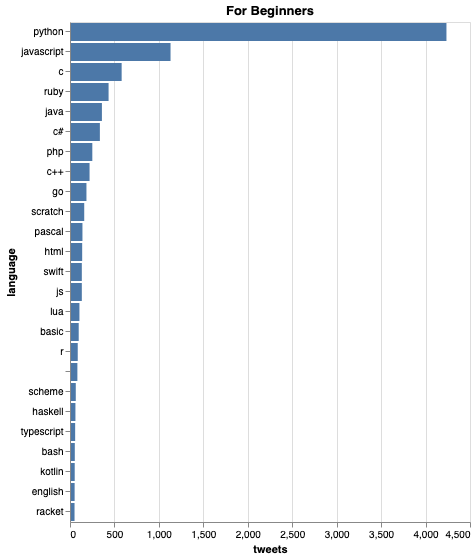

In [102]:
chart('For Beginners', counter['for beginners']).display()

People also invented their own categories. Let's see what the most invented cateogries were:

In [117]:
alt_cats = Counter()
for cat_name in counter.keys():
    if cat_name not in ['first language', 'had difficulties', 'most used', 
                        'totally hate', 'most loved', 'for beginners']:
        alt_cats[cat_name] = sum(counter[cat_name].values())

for cat, count in alt_cats.most_common(100):
    print('{:>10} - {}'.format(count, cat))

       370 - curious about
       192 - want to learn
       179 - best for beginners
       108 - totally hated
       100 - others used
        81 - dislike
        70 - had difficulty
        61 - need to learn
        59 - for beginner
        45 - for begginers
        44 - most excited about lately
        43 - currently
        42 - most wanna try
        39 - explored/can get started quickly
        37 - weirdly enjoy
        37 - hate
        37 - next to try
        37 - beginners
        36 - want to try
        36 - strongly dislike
        32 - most hated
        29 - languages tried
        28 - love/hate relationship
        27 - has difficulties
        27 - most want to try
        26 - beginner
        25 - like to try
        25 - totaly hate
        24 - most esoteric
        23 - desired
        23 - for beginers
        23 - dabbled in
        22 - total hate
        22 - would like to explore
        22 - first language(s)
        21 - recommend for beginners
   

As you can see there a bunch of expected typos. But there were a few categories that indicated that the desire to learn a language, like:

- curious about
- want to learn
- need to learn
- want to learn (dabbled in)
- would like to explore
- most excited about lately
- next to try
- want to try
- i want to learn more

So I decided to merge them, and see what they looked like:

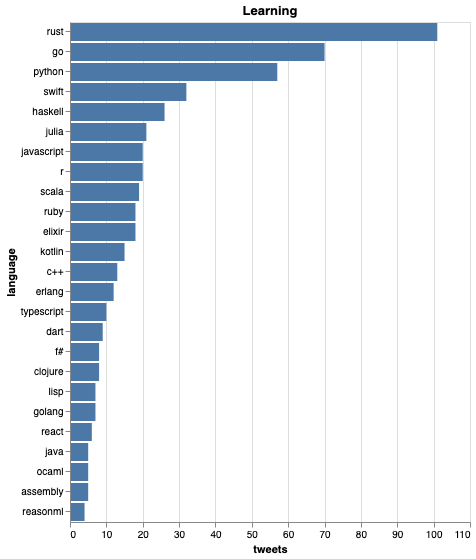

In [127]:
learn = counter['curious about'] + counter['want to learn'] + counter['need to learn'] + \
        counter['want to learn (dabbled in)'] + counter['would like to explore'] + \
        counter['most excited about lately'] + counter['next to try'] + counter['want to try'] + \
        counter['i want to learn more']

chart('Learning', learn).display()